Starting from network from [photometry_from_restricted_mlp_photonly.ipynb](photometry_from_restricted_mlp_photonly.ipynb).

In [1]:
import time
import dill
import datetime
import functools
import multiprocessing
from pathlib import Path
from copy import deepcopy
from collections import defaultdict

import numpy as np

from scipy import integrate

from astropy import units as u
from astropy import table
from astropy.io import fits
from astropy.modeling import models, fitting

from astroquery.svo_fps import SvoFps


from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from emcee import EnsembleSampler
import corner

from tqdm.auto import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


In [3]:
phottab = table.Table.read('spectrophotometry.ecsv', format='ascii.ecsv')
phottab.colnames

['specname',
 'absmag_F275W_vega',
 'absmag_F275W_AB',
 'absmag_F275W_ST',
 'absmag_F336W_vega',
 'absmag_F336W_AB',
 'absmag_F336W_ST',
 'absmag_F475W_vega',
 'absmag_F475W_AB',
 'absmag_F475W_ST',
 'absmag_F814W_vega',
 'absmag_F814W_AB',
 'absmag_F814W_ST',
 'absmag_F110W_vega',
 'absmag_F110W_AB',
 'absmag_F110W_ST',
 'absmag_F160W_vega',
 'absmag_F160W_AB',
 'absmag_F160W_ST']

In [4]:
phottensors = []
bandnms = 'F275W,F336W,F475W,F814W,F110W,F160W'.split(',')
for bandnm in bandnms:
    phottensors.append(torch.from_numpy(phottab[f'absmag_{bandnm}_AB']))
    
phottensors = torch.vstack(phottensors).T.to(device, dtype=tensor_dtype)
phottensors.shape

torch.Size([7508, 6])

In [5]:
datapath = Path('../fullgrid/')

In [6]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

In [7]:
goodspecmask = np.array(['BUNIT' in fits.getheader(p) for p in tqdm(allspecpaths)])
goodspecpaths = [p for i,p in enumerate(allspecpaths) if goodspecmask[i]]
assert len(goodspecpaths) == np.sum(goodspecmask)

  0%|          | 0/7559 [00:00<?, ?it/s]

In [8]:
teff = torch.tensor([fits.getval(p, 'PHXTEFF') for p in goodspecpaths])
logg = torch.tensor([fits.getval(p, 'PHXLOGG') for p in goodspecpaths])
feh = torch.tensor([fits.getval(p, 'PHXM_H') for p in goodspecpaths])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

In [9]:
class PhotEmulator(nn.Module):
    def __init__(self, feature_mlp_nneurons=[3, 512], phot_nneurons=[512, 512,  6], teffindex=0, 
                       logifyteff=False,activation_cls=nn.GELU, batchnorm=False):
        super().__init__()

        self.teffindex = teffindex
        self.logifyteff = logifyteff

        self.prenorm = nn.Linear(feature_mlp_nneurons[0], feature_mlp_nneurons[0])
        self.prenorm.weight = nn.Parameter(torch.eye(self.prenorm.in_features), requires_grad=False)
        self.prenorm.bias = nn.Parameter(torch.zeros_like(self.prenorm.bias), requires_grad=False)

        # note that outscale generally is *not* auto-applied, but is inferred from training data to be applied after training
        self.outscale = nn.Linear(phot_nneurons[-1], phot_nneurons[-1])
        self.outscale.weight = nn.Parameter(torch.eye(self.outscale.in_features), requires_grad=False)
        self.outscale.bias = nn.Parameter(torch.zeros_like(self.outscale.bias), requires_grad=False)
        
        noutpixels = phot_nneurons[-1]

        mlp_layers = []
        if batchnorm == 'first':
            mlp_layers.append(nn.BatchNorm1d(feature_mlp_nneurons[0]))
        for ni, no in zip(feature_mlp_nneurons[:-1], feature_mlp_nneurons[1:]):
            mlp_layers.append(nn.Linear(ni, no))
            if batchnorm and (batchnorm != 'first'):
                mlp_layers.append(nn.BatchNorm1d(no))
            mlp_layers.append(activation_cls())


        self.mlp = nn.Sequential(*mlp_layers)

        assert feature_mlp_nneurons[-1] == phot_nneurons[0], 'the mlp must end with the same number of neurons as the phot net starts with!' 

        
        phot_layers = []
        for ni, no in zip(phot_nneurons[:-1], phot_nneurons[1:]):
            phot_layers.append(nn.Linear(ni, no))
            phot_layers.append(activation_cls())
        del phot_layers[-1] # last layer should have no activation
        self.photnet = nn.Sequential(*phot_layers)

        self.optimizer_cls = torch.optim.AdamW
        self.scheduler_init = None

        self.loss_fcn = nn.MSELoss()

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype


    def convert_input(self, t):
        t = torch.atleast_2d(t)
        return t.to(self.device, dtype=self.dtype)

    def forward(self, x, in_convert=True):
        """
        the output is not descaled here, use `forward_descale` if that's what's desired
        """
        if in_convert:
            x = self.convert_input(x)
        
        if self.logifyteff:
            x = x.clone()
            x[..., self.teffindex] = torch.log10(x[..., self.teffindex])

        
    
        ym = self.mlp(self.prenorm(x))
        return self.photnet(ym)

    def descale_forward(self, *args, **kwargs):
        return self.outscale(self.forward(*args, **kwargs))

    def get_inverse_outscale(self):
        l = nn.Linear(self.outscale.out_features, self.outscale.in_features, device=self.device, dtype=self.dtype)
        with torch.no_grad():
            si = torch.linalg.inv(self.outscale.weight.detach())
            l.weight[:] = si
            l.bias[:] = -torch.diag(si)*self.outscale.bias.detach()
        return l

    def train_and_validate(self, infeatures, phot, nepochs, batch_size,
                                 tetrsplit=[.3, .7], split_seed=42, optkwargs={}, shuffle_batches=True,
                                 setnormscale=True):

        if setnormscale:
            mi = infeatures.mean(0).to(self.device, dtype=self.dtype)
            si = infeatures.std(0).to(self.device, dtype=self.dtype)
            self.prenorm.weight[:] = torch.eye(si.shape[0], device=self.device, dtype=self.dtype) * (1/si)
            self.prenorm.bias[:] = -mi/si
            
            mo = phot.mean(0).to(self.device, dtype=self.dtype)
            so = phot.std(0).to(self.device, dtype=self.dtype)
            self.outscale.weight[:] = torch.eye(so.shape[0], device=self.device, dtype=self.dtype) * so
            self.outscale.bias[:] = mo
            
        with torch.no_grad():
            sphot = self.get_inverse_outscale()(phot)
            
        dataset = TensorDataset(self.convert_input(infeatures), sphot)
        
        split_data = random_split(dataset, tetrsplit, torch.Generator().manual_seed(split_seed))
        valid_data, train_data = split_data

        optimizer = self.optimizer_cls(self.parameters(), **optkwargs)
        if self.scheduler_init is not None:
            scheduler = self.scheduler_init(optimizer)
            
        niters = 0
        valid_losses = []
        valid_niters = []    
        train_losses = []
        train_niters = []
        lrs = []

        valid_x = valid_data.dataset.tensors[0][valid_data.indices]
        valid_ys = valid_data.dataset.tensors[1][valid_data.indices]
        def validation_fcn():
            self.eval()
            with torch.no_grad():
                pred = self(valid_x, in_convert=False)
                valid_loss = self.loss_fcn(pred, valid_ys).item()
                valid_losses.append(valid_loss)
                valid_niters.append(niters)
            return valid_loss

        for _ in (pbar := tqdm(range(nepochs))):
            self.train()

            for data in DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_batches):
                X, Y = data[:2]
                optimizer.zero_grad()
                
                pred = self(X, in_convert=False)
                loss = self.loss_fcn(pred, Y)
                
                loss.backward()
                optimizer.step()
        
                niters += X.shape[0]
                
                train_losses.append(loss.item())
                train_niters.append(niters)

            if self.scheduler_init is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
            valid_loss = validation_fcn()
            if self.scheduler_init  is None:
                pbar.set_description(f'valid loss={valid_loss:.3e}')
            else:
                pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')

        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data

    def save(self, outpath=None, extrasuffix=''):
        """
        saves the *state dict* in the target path
        """
        if outpath is None:
            base = Path('.')
            dts = datetime.datetime.now().isoformat().split('.')[0].replace(':','').replace('-','')
            outpath = base / f"photemulator{extrasuffix}_{dts}.pth"
        else:
            outpath = Path(outpath)

        codepath = outpath.with_suffix('.py')
        if codepath.with_suffix('.pth') == codepath:
            raise ValueError("output path can't be a .py file!")

        try:
            src = dill.source.getsource(self, alias ='_DONT_USE_ME')
        except Exception as e:
            print(e)
            src = None
            
        if src is None:
            print(f'could not get source code for {self.__class__}, save to {codepath} manually')
        else:
            # dill doesn't do imports, and it adds a creation of the object we want to preserve for info but supress
            import_lines = ['import torch', 'from torch import nn', '# other imports may be missing that cannot be guessed', '']
            srclines = []
            comment = False
            for l in src.split('\n'):
                if l.startswith('_DONT_USE_ME = '):
                    comment = True
                if comment:
                    srclines.append('# '+l)
                else:
                    srclines.append(l)

            src = '\n'.join(import_lines + srclines)
            
            with codepath.open('w') as f:
                f.write(src)
            
        torch.save(self.state_dict(), outpath)

        return outpath, codepath

    def load_infer(self, inpath):
        """
        loads the given *state dict*, requires manually adding class
        """
        self.load_state_dict(torch.load(inpath, weights_only=True))
        self.eval()

0.26783599999999996 M parameters


  0%|          | 0/10000 [00:00<?, ?it/s]

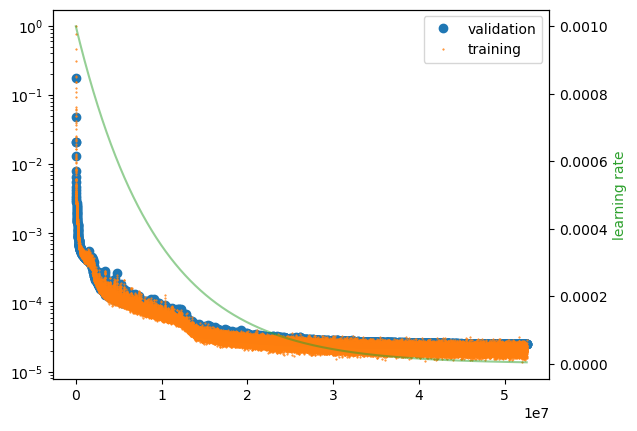

In [11]:
nrestarts = 0
nperrestart = 10000
nepochs = nperrestart if nrestarts == 0 else (nperrestart * nrestarts)


startlr = 1e-3
endlr = 4e-6

model = PhotEmulator()
#model = PhotEmulator(feature_mlp_nneurons=[3, 512], phot_nneurons=[512, 512,  6], logifyteff=False, batchnorm=False)
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')

model = model.to(device, dtype=tensor_dtype)

model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
if nrestarts == 0:
    gamma = (endlr/startlr)**(1/nepochs)
    model.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=gamma)
else:
    model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)

valid, train, lrs, data_split =  model.train_and_validate(infeatures, phottensors, nepochs, int(np.ceil(infeatures.shape[0]/10)),
                                                         optkwargs=dict(lr=startlr, weight_decay=0))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(4.5879686e-05),
 np.float32(0.0049866647),
 [(np.float32(-0.0011849066), np.float32(0.05701585)),
  (np.float32(-0.0006596882), np.float32(0.046309255)),
  (np.float32(-0.00026806883), np.float32(0.028573768)),
  (np.float32(-0.00025889024), np.float32(0.0145480335)),
  (np.float32(8.739134e-05), np.float32(0.010345228)),
  (np.float32(0.00029441918), np.float32(0.011365566))])

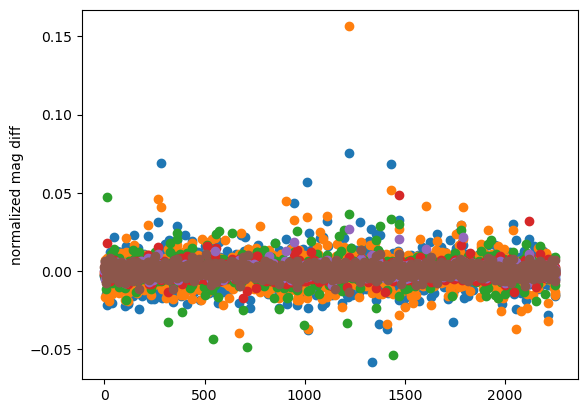

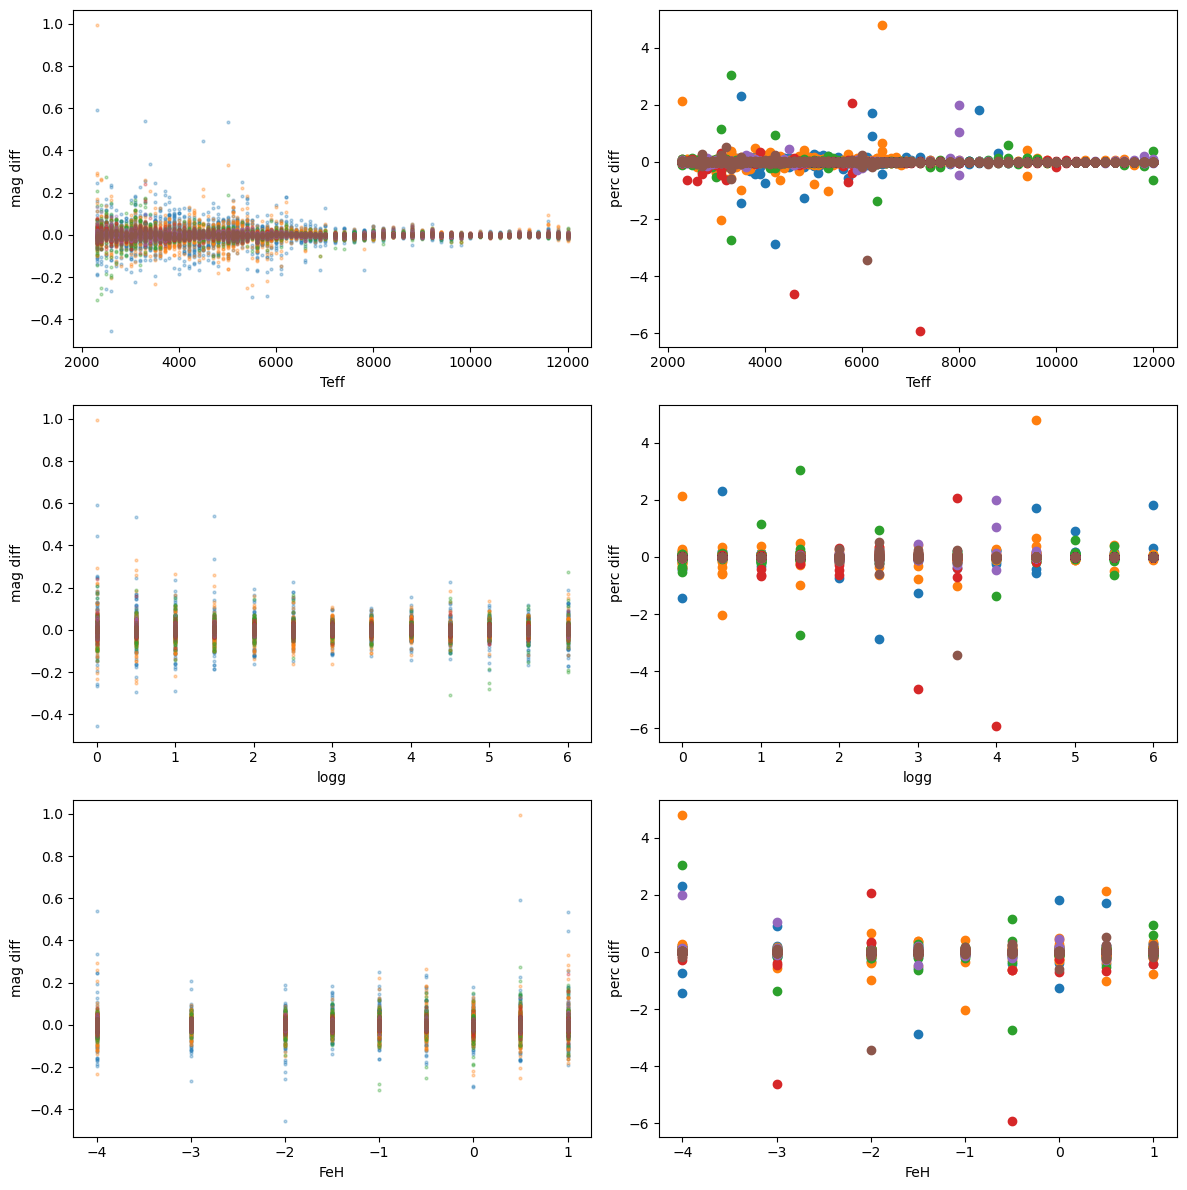

In [12]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')

ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()



magdiff = (model.outscale(Y) - model.outscale(pred)).detach().cpu().numpy()
np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy()), list(zip(np.mean(magdiff, axis=0), np.std(magdiff,axis=0)))

In [13]:
modelsunphot = model.outscale(model(torch.Tensor([[5800, 4.43, 0]])))
modelsunphot

tensor([[8.1995, 6.5023, 5.0367, 4.4880, 4.4989, 4.5924]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Those are plausible sun answers!

In [14]:
# uncomment this to wipe previously saved versions
#!rm photemulator*.py photemulator*.pth

In [15]:
saved = model.save()
saved

(PosixPath('photemulator_20250412T010910.pth'),
 PosixPath('photemulator_20250412T010910.py'))

Confirm loaded version behaves the same:

In [16]:
m = PhotEmulator()
m.load_infer(saved[0]) 
m = m.to(device, dtype=tensor_dtype)

msunphot = m.descale_forward(torch.Tensor([[5800, 4.43, 0]]))

assert torch.allclose(msunphot, modelsunphot)

msunphot

tensor([[8.1995, 6.5023, 5.0367, 4.4880, 4.4989, 4.5924]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

# Now try inferring from photometry

In [17]:
def mags_from_stellar_params(teff, logg, feh, model=model):
    inten = model.convert_input(torch.Tensor([[teff, logg, feh]]))
    return model.descale_forward(inten).detach().cpu()

def logpri(x):
    teffs, loggs, fehs = x
    if teffs < 2300 or teffs > 12000:
        return -np.inf
    if loggs < 0 or loggs > 6:
        return -np.inf
    if fehs < -4 or fehs > 1:
        return -np.inf
    return 0

LTWOPI = -2*np.pi
def loglike(x, magdata, magerrs, model=model):
    mags = mags_from_stellar_params(*[torch.tensor(xi) for xi in x], model=model).numpy()
    return -0.5*(np.log(magerrs) + ((mags-magdata)/magerrs)**2) - LTWOPI

def logprob(x, *args, **kwargs):
    lp = logpri(x)
    if lp == -np.inf:
        return -np.inf
    else:
        return np.sum(lp + loglike(x, *args, **kwargs))


magdata = np.array([8.1828, 6.5063, 5.0457, 4.4910, 4.5033, 4.5908])
magerrs = np.array([0.2, 0.15, 0.1, 0.1, 0.15, 0.25])

dim_names = 'teffs, loggs, fehs'.split(', ')
sampler = EnsembleSampler(len(dim_names)*3, len(dim_names), logprob,
                         args=(magdata, magerrs))

x0 = np.array([np.random.rand(len(dim_names)*3)*9000 + 2300, 6*np.random.rand(len(dim_names)*3), -4 + 5*np.random.rand(len(dim_names)*3)]).T
res = sampler.run_mcmc(x0, 20000, progress='notebook')

  0%|          | 0/20000 [00:00<?, ?it/s]

emcee: Exception while calling your likelihood function:
  params: [5.90364141e+03 4.63198851e+00 9.31626550e-01]
  args: (array([8.1828, 6.5063, 5.0457, 4.491 , 4.5033, 4.5908]), array([0.2 , 0.15, 0.1 , 0.1 , 0.15, 0.25]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/erik/astro/phoenix/ml_generation/.pixi/envs/cuda/lib/python3.11/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4118/1760798543.py", line 25, in logprob
    return np.sum(lp + loglike(x, *args, **kwargs))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4118/1760798543.py", line 17, in loglike
    mags = mags_from_stellar_params(*[torch.tensor(xi) for xi in x], model=model).numpy()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4118/1760798543.py", line 2, in mags_from_stellar_params
    inten = model.convert_input(torch.Tensor([[teff, logg, feh]]))
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4118/1743960165.py", line 58, in convert_input
    return t.to(self.device, dtype=self.dtype)
 

KeyboardInterrupt: 

(1579, 0.025165695359475018)

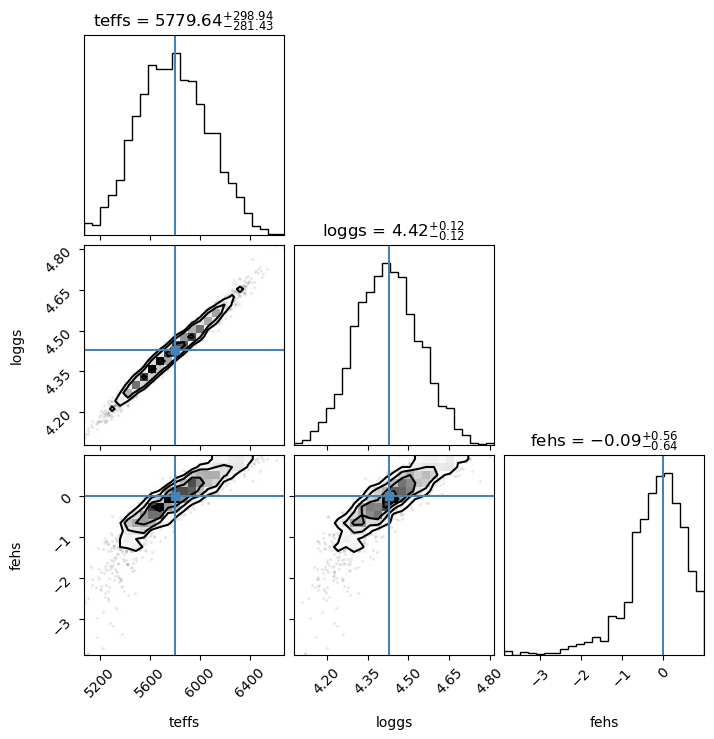

In [18]:
subchain = sampler.flatchain[int(sampler.flatchain.shape[0]/2)::int(np.ceil(sampler.acor.mean()))]
dcor = corner.corner(subchain, labels=dim_names, truths=[5800, 4.43, 0], bins=25, show_titles=True)
len(subchain), len(subchain)**-0.5

It works! Now compare to a gaussian-like estimate

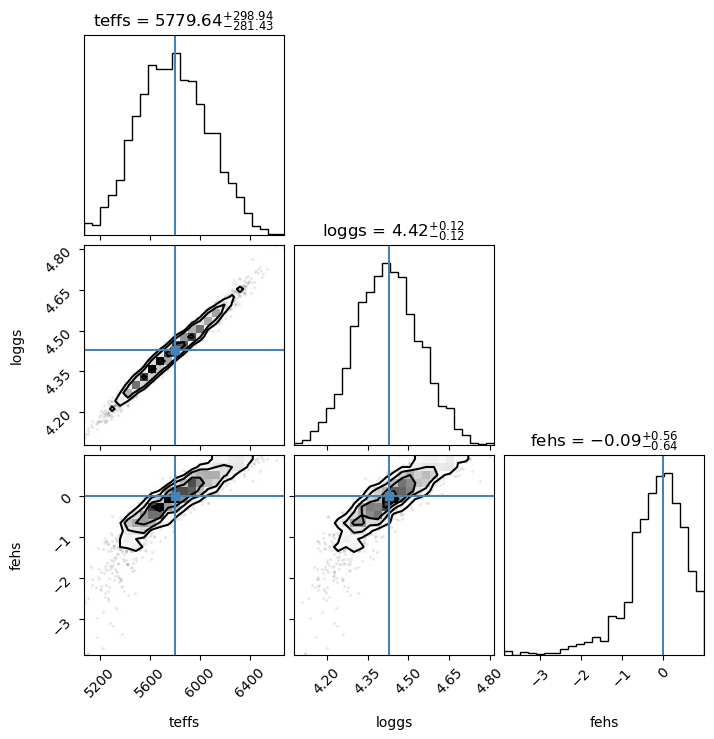

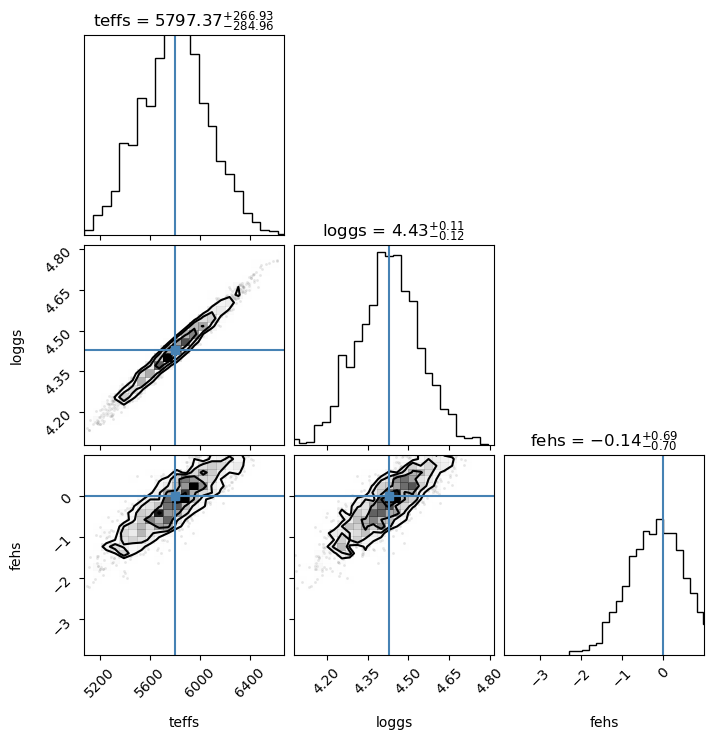

In [19]:
cov = np.cov(subchain.T)
mean = np.mean(subchain, axis=0)
normal_approx_chain  = np.random.multivariate_normal(mean, cov, len(subchain))

cor = corner.corner(normal_approx_chain, labels=dim_names, truths=[5800, 4.43, 0], bins=25, show_titles=True)

for a0, a1 in zip(dcor.axes, cor.axes):
    a1.set_xlim(*a0.get_xlim())
    a1.set_ylim(*a0.get_ylim())

dcor

# Also create a vegamag emulator to match phat

In [10]:
phottensorsvega = []
bandnms = 'F275W,F336W,F475W,F814W,F110W,F160W'.split(',')
for bandnm in bandnms:
    phottensorsvega.append(torch.from_numpy(phottab[f'absmag_{bandnm}_vega']))
    
phottensorsvega = torch.vstack(phottensorsvega).T.to(device, dtype=tensor_dtype)
phottensorsvega.shape

torch.Size([7508, 6])

0.26783599999999996 M parameters


  0%|          | 0/10000 [00:00<?, ?it/s]

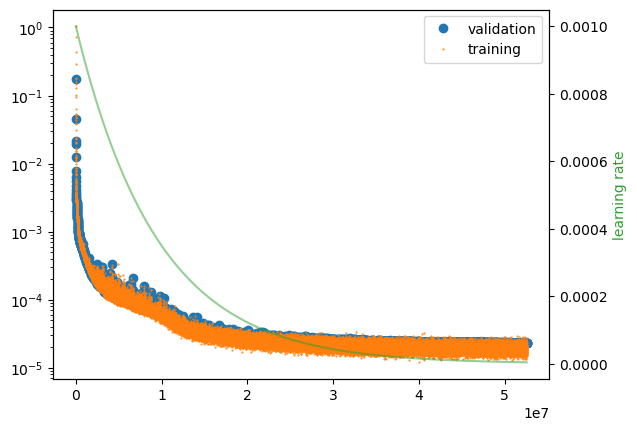

In [11]:
nrestarts = 0
nperrestart = 10000
nepochs = nperrestart if nrestarts == 0 else (nperrestart * nrestarts)


startlr = 1e-3
endlr = 4e-6

model = PhotEmulator()
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')

model = model.to(device, dtype=tensor_dtype)

model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
if nrestarts == 0:
    gamma = (endlr/startlr)**(1/nepochs)
    model.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=gamma)
else:
    model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)

valid, train, lrs, data_split =  model.train_and_validate(infeatures, phottensorsvega, nepochs, int(np.ceil(infeatures.shape[0]/10)),
                                                         optkwargs=dict(lr=startlr, weight_decay=0))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(5.543922e-06),
 np.float32(0.004838428),
 [(np.float32(-0.00056802196), np.float32(0.05289271)),
  (np.float32(0.0007163653), np.float32(0.044523213)),
  (np.float32(-8.4485626e-05), np.float32(0.029164348)),
  (np.float32(-0.00051784434), np.float32(0.016331442)),
  (np.float32(-5.8701342e-05), np.float32(0.010659154)),
  (np.float32(0.0002761944), np.float32(0.010488567))])

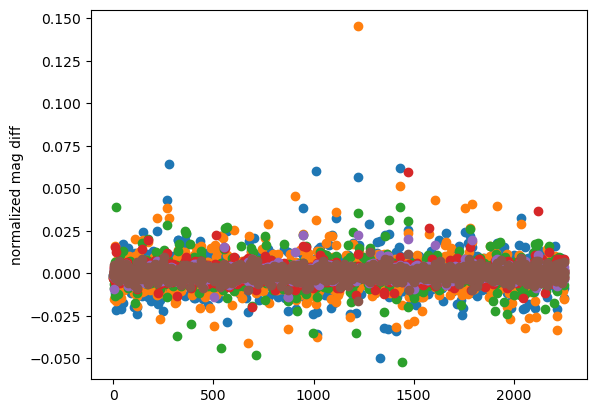

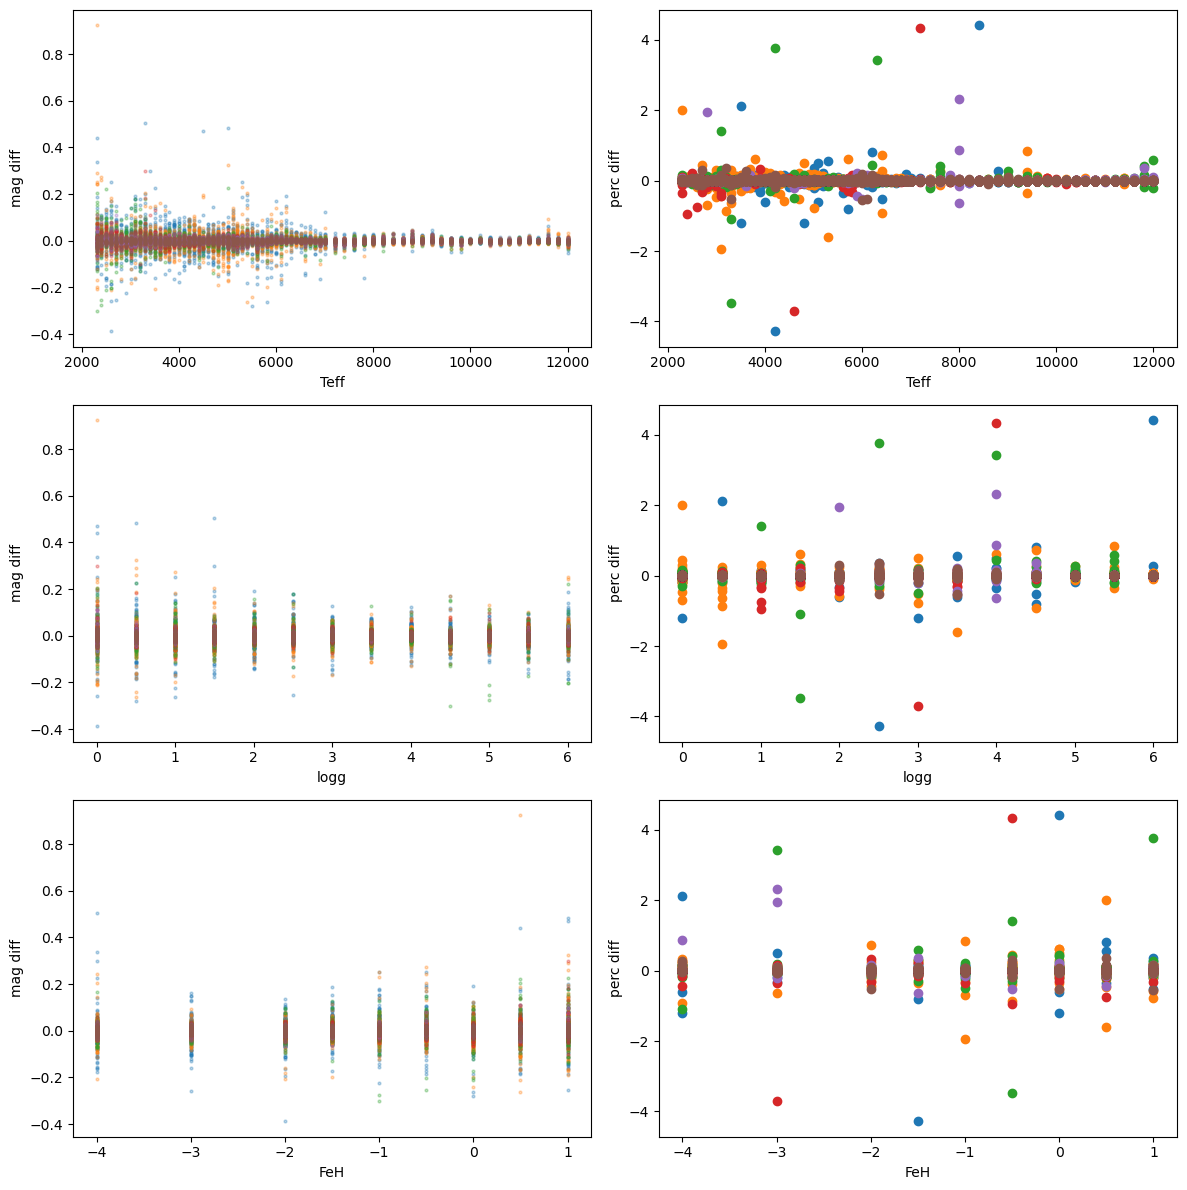

In [12]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')

ptscale = phottensorsvega.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()



magdiff = (model.outscale(Y) - model.outscale(pred)).detach().cpu().numpy()
np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy()), list(zip(np.mean(magdiff, axis=0), np.std(magdiff,axis=0)))

In [13]:
saved = model.save(extrasuffix='_vega')
saved

(PosixPath('photemulator_vega_20250416T171629.pth'),
 PosixPath('photemulator_vega_20250416T171629.py'))

## Compare that inference is similar

  0%|          | 0/20000 [00:00<?, ?it/s]

(1637, 0.024715856229864275)

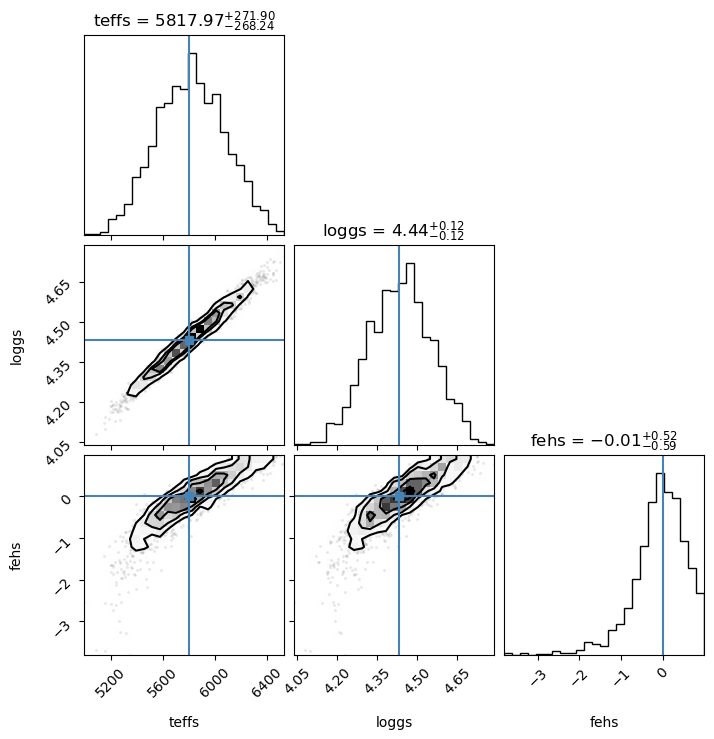

In [18]:
magdata = np.array([6.7015, 5.3695, 5.1564, 4.0666, 3.7370, 3.3315])
magerrs = np.array([0.2, 0.15, 0.1, 0.1, 0.15, 0.25])

dim_names = 'teffs, loggs, fehs'.split(', ')
sampler = EnsembleSampler(len(dim_names)*3, len(dim_names), logprob,
                         args=(magdata, magerrs, model))

x0 = np.array([np.random.rand(len(dim_names)*3)*9000 + 2300, 6*np.random.rand(len(dim_names)*3), -4 + 5*np.random.rand(len(dim_names)*3)]).T
res = sampler.run_mcmc(x0, 20000, progress='notebook')

subchain = sampler.flatchain[int(sampler.flatchain.shape[0]/2)::int(np.ceil(sampler.acor.mean()))]
dcor = corner.corner(subchain, labels=dim_names, truths=[5800, 4.43, 0], bins=25, show_titles=True)
len(subchain), len(subchain)**-0.5